In [1]:
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime, timedelta
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import  mean_squared_error
import statsmodels.api as sm

warnings.filterwarnings('ignore')

In [2]:
oil_data = pd.read_csv('../b. Datasets/Oil Prices/Oil Prices.csv')

In [3]:
oil_data.columns

Index(['date', ' value'], dtype='object')

In [4]:
oil_data.rename(columns={" value": "Value"}, inplace=True)
oil_data.columns

Index(['date', 'Value'], dtype='object')

In [5]:
display(oil_data.head(2))
display(oil_data.tail(2))

,date,Value
0,01-01-2010,8.2
1,01-02-2010,8.4


,date,Value
90,01-07-2017,10.10
91,01-08-2017,10.14


In [6]:
date_feature = pd.date_range(start='01-01-2010', end='08-01-2017', freq='MS')
oil_data.drop(labels='date', axis=1, inplace=True)
oil_data.insert(loc=0, column='Date', value=date_feature)

In [7]:
oil_data.isna().sum()

Date     0
Value    0
dtype: int64

In [8]:
display(oil_data.head(2))
display(oil_data.tail(2))

,Date,Value
0,2010-01-01,8.2
1,2010-02-01,8.4


,Date,Value
90,2017-07-01,10.10
91,2017-08-01,10.14


In [9]:
oil_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    92 non-null     datetime64[ns]
 1   Value   92 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.6 KB


In [10]:
oil_data.describe()

,Date,Value
count,92,92.000000
mean,2013-10-16 01:33:54.782608640,9.737283
min,2010-01-01 00:00:00,8.200000
25%,2011-11-23 12:00:00,9.500000
50%,2013-10-16 12:00:00,9.800000
75%,2015-09-08 12:00:00,10.100000
max,2017-08-01 00:00:00,10.630000
std,NaN,0.530958


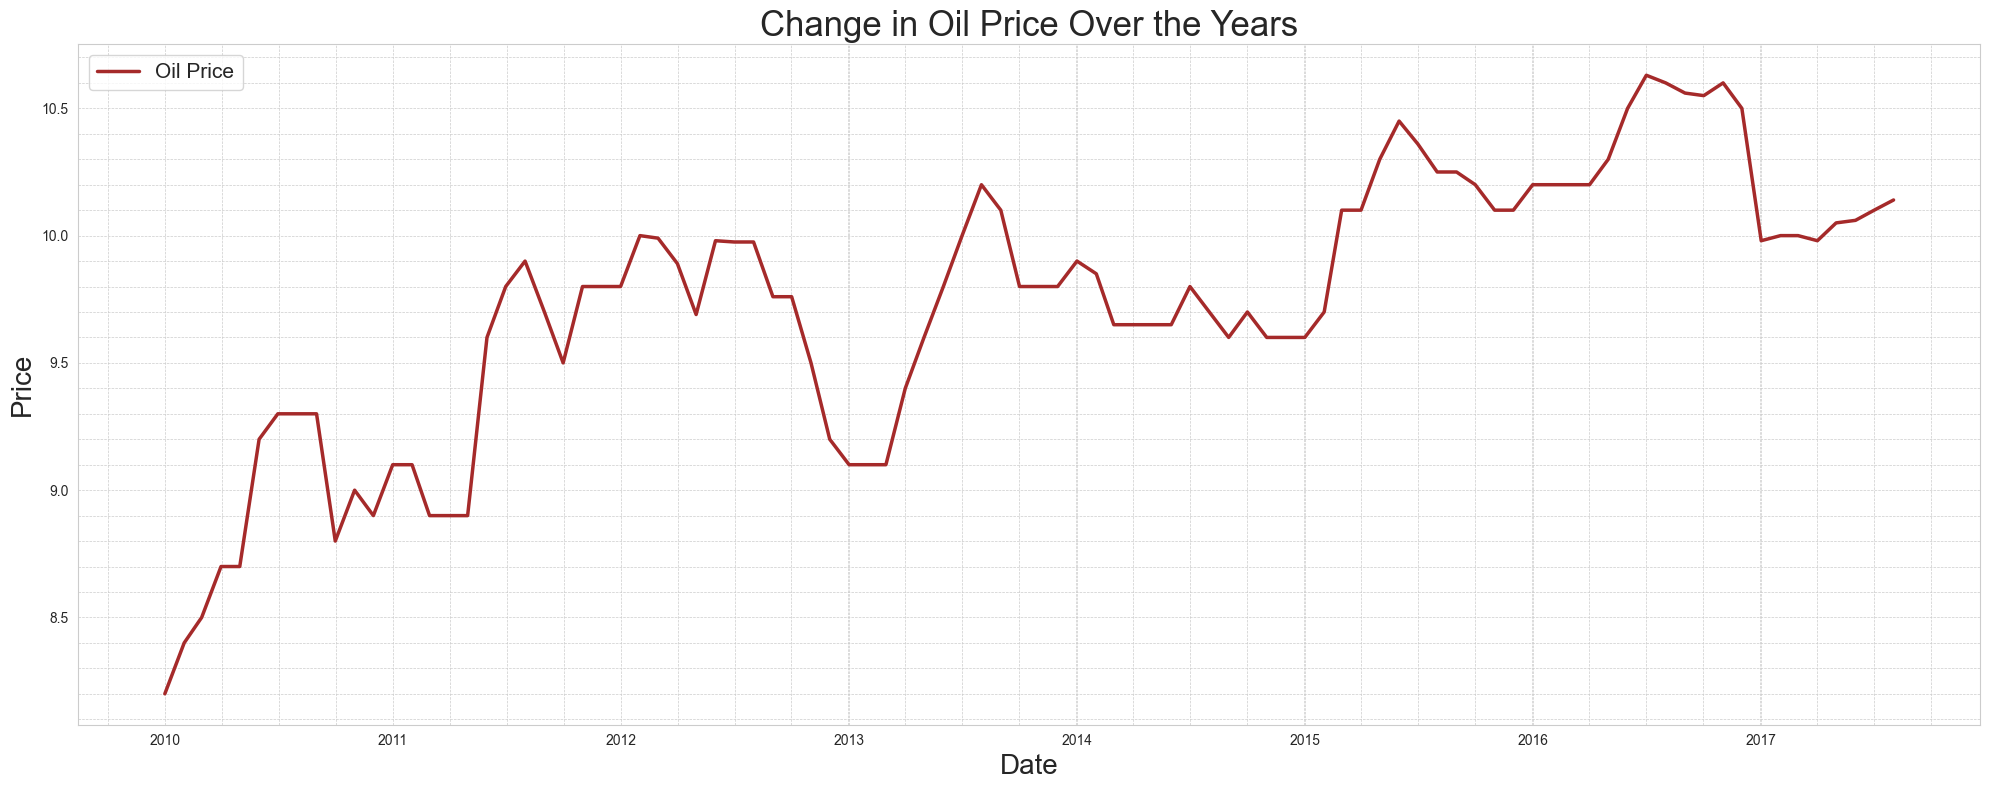

In [11]:
plt.figure(figsize=(20, 8))
sns.set_style('whitegrid')
sns.lineplot(data=oil_data, x='Date', y='Value', color='brown', linewidth=2.5)
plt.xlabel("Date", fontsize=20)
plt.ylabel("Price", fontsize=20)
plt.title("Change in Oil Price Over the Years", fontsize=25)
plt.minorticks_on()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend(['Oil Price'], loc='upper left', fontsize=15)
plt.tight_layout()
plt.show()

In [12]:
oil_data.set_index(keys='Date', inplace=True)

In [13]:
adf_test = adfuller(oil_data['Value'])

adf_result = pd.Series(adf_test[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key, value in adf_test[4].items():
    adf_result[f'Critical Value ({key})'] = value

print(adf_result)

if adf_result['p-value'] < 0.05:
    print("The data is stationary. Differencing is not required.")
else:
    print("The data is not stationary. Differencing is required.")

Test Statistic                 -2.824651
p-value                         0.054838
#Lags Used                      1.000000
Number of Observations Used    90.000000
Critical Value (1%)            -3.505190
Critical Value (5%)            -2.894232
Critical Value (10%)           -2.584210
dtype: float64
The data is not stationary. Differencing is required.


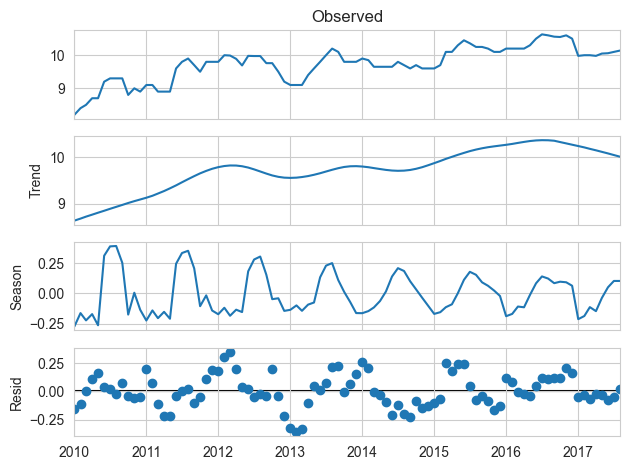

In [14]:
decomposition = STL(oil_data).fit()
decomposition.plot();

In [15]:
train_end = datetime(2015, 8, 1)

train_data = oil_data[:train_end]
validation_data = oil_data[train_end + timedelta(days=31):]

In [16]:
display(train_data.head(2))
display(train_data.tail(2))
display(validation_data.head(2))
display(validation_data.tail(2))

,Value
Date,
2010-01-01,8.2
2010-02-01,8.4


,Value
Date,
2015-07-01,10.36
2015-08-01,10.25


,Value
Date,
2015-09-01,10.25
2015-10-01,10.20


,Value
Date,
2017-07-01,10.10
2017-08-01,10.14


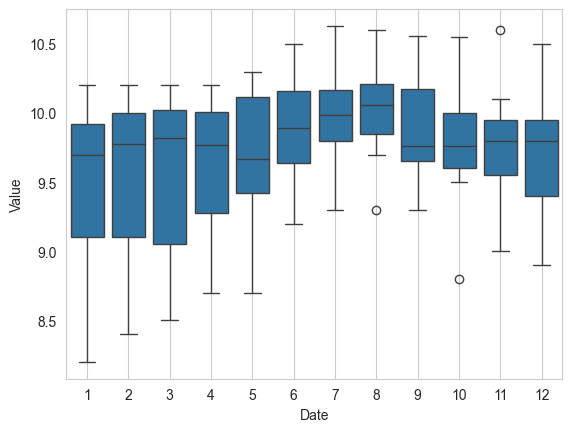

In [17]:
sns.boxplot(x=oil_data.index.month, y=oil_data['Value'])
plt.grid();

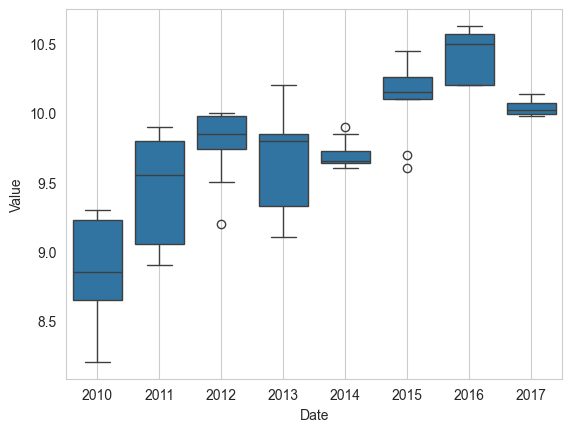

In [18]:
sns.boxplot(x=oil_data.index.year, y=oil_data['Value'])
plt.grid();

In [19]:
import itertools
p = q = range(0, 4)
d = range(1, 3)
pdq = list(itertools.product(p, d, q))

In [20]:
akaike_information_criterion = pd.DataFrame(columns=['param', 'AIC'])
akaike_information_criterion

,param,AIC


In [21]:
for param in pdq:
    try:
        mod = ARIMA(train_data, order=param)
        results_Arima = mod.fit()
        print('ARIMA{} - AIC:{}'.format(param, results_Arima.aic))
        akaike_information_criterion = pd.concat([akaike_information_criterion, pd.DataFrame({'param': [param], 'AIC': [results_Arima.aic]})], ignore_index=True)
    except Exception as e:
        print(f"Error with parameters {param}: {e}")
        continue


ARIMA(0, 1, 0) - AIC:-26.97014680343474
ARIMA(0, 1, 1) - AIC:-26.189829135194497
ARIMA(0, 1, 2) - AIC:-25.940444075986893
ARIMA(0, 1, 3) - AIC:-25.404561399113298
ARIMA(0, 2, 0) - AIC:8.920670816254582
ARIMA(0, 2, 1) - AIC:-20.985823135857935
ARIMA(0, 2, 2) - AIC:-20.109481697668823
ARIMA(0, 2, 3) - AIC:-19.79131033591639
ARIMA(1, 1, 0) - AIC:-26.440123247296043
ARIMA(1, 1, 1) - AIC:-24.569892426761854
ARIMA(1, 1, 2) - AIC:-24.335446229497983
ARIMA(1, 1, 3) - AIC:-24.443416215336114
ARIMA(1, 2, 0) - AIC:-5.465173313495502
ARIMA(1, 2, 1) - AIC:-20.335154144336904
ARIMA(1, 2, 2) - AIC:-18.39323557913683
ARIMA(1, 2, 3) - AIC:-16.73903279336323
ARIMA(2, 1, 0) - AIC:-24.8538181006584
ARIMA(2, 1, 1) - AIC:-23.09345272673939
ARIMA(2, 1, 2) - AIC:-26.62469649843034
ARIMA(2, 1, 3) - AIC:-28.53871238100554
ARIMA(2, 2, 0) - AIC:-5.131893236527988
ARIMA(2, 2, 1) - AIC:-18.721717934295004
ARIMA(2, 2, 2) - AIC:-16.882527612050215
ARIMA(2, 2, 3) - AIC:-20.630886569509443
ARIMA(3, 1, 0) - AIC:-24.2589

In [22]:
akaike_information_criterion.sort_values(by="AIC", ascending=True, inplace=True)
akaike_information_criterion

,param,AIC
19,"(2, 1, 3)",-28.538712
0,"(0, 1, 0)",-26.970147
18,"(2, 1, 2)",-26.624696
8,"(1, 1, 0)",-26.440123
1,"(0, 1, 1)",-26.189829
2,"(0, 1, 2)",-25.940444
3,"(0, 1, 3)",-25.404561
16,"(2, 1, 0)",-24.853818
9,"(1, 1, 1)",-24.569892
11,"(1, 1, 3)",-24.443416


In [23]:
model = ARIMA(train_data, order=(2,1,3))
results_Arima = model.fit()
print(results_Arima.summary())

                               SARIMAX Results                                
Dep. Variable:                  Value   No. Observations:                   68
Model:                 ARIMA(2, 1, 3)   Log Likelihood                  20.269
Date:                Mon, 18 Nov 2024   AIC                            -28.539
Time:                        20:24:15   BIC                            -15.311
Sample:                    01-01-2010   HQIC                           -23.304
                         - 08-01-2015                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.6713      0.101    -16.508      0.000      -1.870      -1.473
ar.L2         -0.9159      0.088    -10.427      0.000      -1.088      -0.744
ma.L1          1.9431      0.146     13.293      0.0

In [25]:
ARIMA_predictions=results_Arima.forecast(steps=24)
ARIMA_pred=ARIMA_predictions.cumsum()

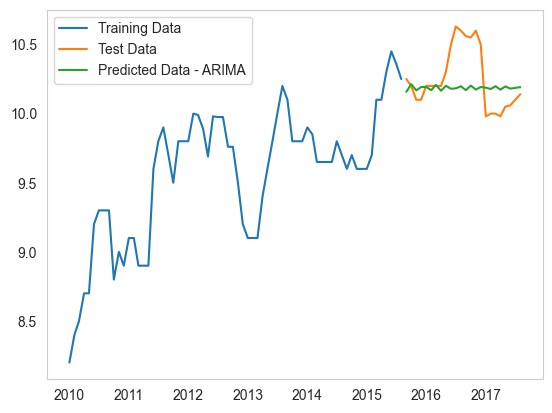

In [27]:
ARIMA_predictions_df = pd.DataFrame(ARIMA_predictions)
test_rmse = mean_squared_error(validation_data['Value'], ARIMA_predictions_df['predicted_mean'], squared=False)
 
print(test_rmse)

0.22783034282538314


In [28]:
p = q = range(0, 4)
d= range(1, 2)
pdq = list(itertools.product(p, d, q))

model_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Model...')
print('Model: {}{}'.format(pdq[1], model_pdq[1]))
print('Model: {}{}'.format(pdq[1], model_pdq[2]))
print('Model: {}{}'.format(pdq[2], model_pdq[3]))
print('Model: {}{}'.format(pdq[2], model_pdq[4]))

Examples of parameter combinations for Model...
Model: (0, 1, 1)(0, 1, 1, 12)
Model: (0, 1, 1)(0, 1, 2, 12)
Model: (0, 1, 2)(0, 1, 3, 12)
Model: (0, 1, 2)(1, 1, 0, 12)


In [37]:
aic_df = pd.DataFrame(columns=['param','seasonal', 'AIC'])
aic_df

,param,seasonal,AIC


In [47]:
for param in pdq:
    for param_seasonal in model_pdq:
            mod = sm.tsa.statespace.SARIMAX(train_data,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            
            results_SARIMA = mod.fit()
            print('SARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results_SARIMA.aic))
            detail = pd.DataFrame({'param': [param], 
                                   'seasonal': [param_seasonal], 
                                   'AIC': [results_SARIMA.aic]})
            aic_df = pd.concat([aic_df, detail], ignore_index=True)


SARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:-2.316457992253726
SARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:-9.786898121025956
SARIMA(0, 1, 0)x(0, 1, 2, 12)12 - AIC:-9.589881324325102
SARIMA(0, 1, 0)x(0, 1, 3, 12)12 - AIC:-3.2086035387112926
SARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:-10.132051180935841
SARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:-9.035938689705716
SARIMA(0, 1, 0)x(1, 1, 2, 12)12 - AIC:-8.834561999802187
SARIMA(0, 1, 0)x(1, 1, 3, 12)12 - AIC:-1.3651766904044624
SARIMA(0, 1, 0)x(2, 1, 0, 12)12 - AIC:-13.45694937670245
SARIMA(0, 1, 0)x(2, 1, 1, 12)12 - AIC:-13.324363399782015
SARIMA(0, 1, 0)x(2, 1, 2, 12)12 - AIC:-10.368570119090556
SARIMA(0, 1, 0)x(2, 1, 3, 12)12 - AIC:0.49575632486841315
SARIMA(0, 1, 0)x(3, 1, 0, 12)12 - AIC:-5.6243855206262285
SARIMA(0, 1, 0)x(3, 1, 1, 12)12 - AIC:-3.3183460997614613
SARIMA(0, 1, 0)x(3, 1, 2, 12)12 - AIC:-2.30124804266997
SARIMA(0, 1, 0)x(3, 1, 3, 12)12 - AIC:1.1400469911628175
SARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:-4.657915137551692
SARIMA(0, 1, 1)x(0, 1, 1

In [48]:
aic_df.sort_values(by='AIC', inplace=True)
aic_df

,param,seasonal,AIC
8,"(0, 1, 0)","(2, 1, 0, 12)",-13.456949
9,"(0, 1, 0)","(2, 1, 1, 12)",-13.324363
24,"(0, 1, 1)","(2, 1, 0, 12)",-11.698820
25,"(0, 1, 1)","(2, 1, 1, 12)",-11.616163
72,"(1, 1, 0)","(2, 1, 0, 12)",-10.468946
...,...,...,...
223,"(3, 1, 1)","(3, 1, 3, 12)",10.371836
255,"(3, 1, 3)","(3, 1, 3, 12)",10.405856
254,"(3, 1, 3)","(3, 1, 2, 12)",10.638535
238,"(3, 1, 2)","(3, 1, 2, 12)",12.221315


In [51]:
sarimax_model = sm.tsa.statespace.SARIMAX(train_data,
                                            order=aic_df['param'][0],
                                            seasonal_order=aic_df['seasonal'][0],
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
sarimax_results = sarimax_model.fit()
sarimax_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Value   No. Observations:                   68
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 12)   Log Likelihood                   2.158
Date:                            Mon, 18 Nov 2024   AIC                             -2.316
Time:                                    20:48:09   BIC                             -0.327
Sample:                                01-01-2010   HQIC                            -1.549
                                     - 08-01-2015                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0541      0.011      4.800      0.000       0.032       0.076
===================================================================================
Ljung-Box (L1) (Q):                   3.61   Jarque-Bera (JB):                 0.41
Prob(Q):                              0.06   Prob(JB):                         0.81
Heteroskedasticity (H):               1.36   Skew:                             0.16
Prob(H) (two-sided):                  0.52   Kurtosis:                         2.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [55]:
sarimax_forecast = sarimax_results.forecast(steps=24)

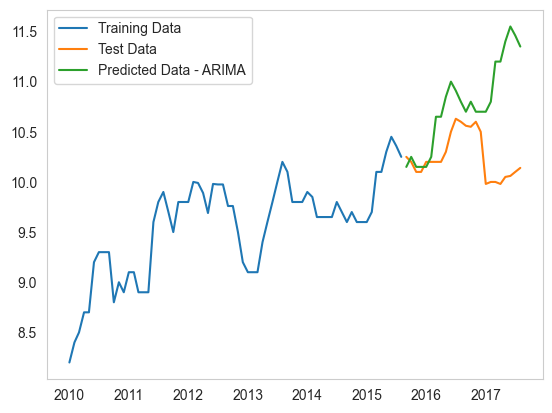

In [56]:
plt.plot(train_data,label='Training Data')
plt.plot(validation_data,label='Test Data')
plt.plot(validation_data.index, sarimax_forecast,label='Predicted Data - SARIMAX')
plt.legend(loc='best')
plt.grid()